In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
fullDf = pd.read_csv('../../Processed Datasets/india.csv', parse_dates=['date'])
fullDf.head()

,AverageTemperature,date
0,17.044,1796-01-01
1,19.193,1796-02-01
2,22.319,1796-03-01
3,27.233,1796-04-01
4,30.035,1796-05-01


In [3]:
# set the date as index
fullDf.set_index("date", inplace=True)
fullDf = fullDf['1970':'2012']
fullDf.head()

,AverageTemperature
date,
1970-01-01,17.400
1970-02-01,19.679
1970-03-01,23.807
1970-04-01,28.212
1970-05-01,30.420


In [4]:
df1 = fullDf.copy()
df1.columns = ["avgTemp"]
df1.head()

,avgTemp
date,
1970-01-01,17.400
1970-02-01,19.679
1970-03-01,23.807
1970-04-01,28.212
1970-05-01,30.420


In [5]:
df1.describe()

,avgTemp
count,516.000000
mean,24.410207
std,4.213053
min,16.241000
25%,20.600000
50%,25.718500
75%,27.492750
max,31.210000


<AxesSubplot:xlabel='date'>

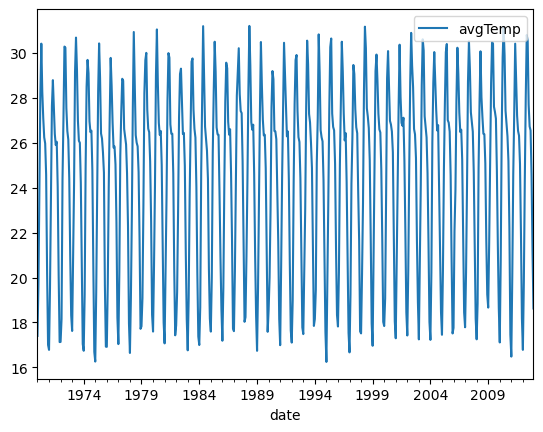

In [6]:
df1.plot()

# Testing for Stationarity:
### 1. Augmented Dickey-Fuller test:
#### Null Hypothesis: Series is not stationary.
#### Alternate Hypothesis: Series is stationary.

In [7]:
from statsmodels.tsa.stattools import adfuller


d:\Anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','No. of Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
adf_test(df1["avgTemp"])

Results of Dickey-Fuller Test:
Test Statistic                  -4.309258
p-value                          0.000428
No. of Lags Used                15.000000
Number of Observations Used    500.000000
Critical Value (1%)             -3.443496
Critical Value (5%)             -2.867338
Critical Value (10%)            -2.569858
dtype: float64


#### The p-value is lesser than the level of significance (0.05) and hence it is strong evidence against the null hypothesis and therefore we reject the null hypothesis. This indicates that our time series data is stationary.

### 2. KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test
#### Null Hypothesis: Series is stationary.
#### Alternate Hypothesis: Series is not stationary.

In [9]:
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression = 'c', nlags = 'legacy')
    kpss_output = pd.Series(kpsstest[0:3], index = ['Test Statistic','p-value','No. of Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
kpss_test(df1["avgTemp"])

Results of KPSS Test:
Test Statistic            0.217324
p-value                   0.100000
No. of Lags Used         19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


d:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [10]:
y = df1['avgTemp'].resample('MS').mean()
y.head()

date
1970-01-01    17.400
1970-02-01    19.679
1970-03-01    23.807
1970-04-01    28.212
1970-05-01    30.420
Freq: MS, Name: avgTemp, dtype: float64

#### The p-value is greater than the level of significance (0.05) and hence it is weak evidence against the null hypothesis and therefore we fail to reject the null hypothesis. This indicates that our time series is stationary.

# Both ADF and KPSS tests are in agreement that the time series data is stationary.


In [11]:
train = y[:'2009']
test = y['2010':]

In [12]:
# from pmdarima.arima import auto_arima

# #The default values of several important parameters for auto_arima function are as follows:
# #max_p=5, max_d=2, max_q=5, max_P=2, max_D=1, max_Q=2

# arima_model = auto_arima(train, seasonal = True, m = 12, stepwise = False, trace = 1, random_state = 10)

In [13]:
import statsmodels.api as sm

model = sm.tsa.statespace.SARIMAX(train, order = (1, 0, 0), seasonal_order = (1, 0, 1, 12), 
                                  enforce_stationarity = False, enforce_invertibility = False)
fitted_model = model.fit(maxiter = 200, method = 'nm')
print(fitted_model.summary())

Optimization terminated successfully.
         Current function value: 0.843882
         Iterations: 191
         Function evaluations: 333
                                      SARIMAX Results                                       
Dep. Variable:                              avgTemp   No. Observations:                  480
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -405.063
Date:                              Mon, 08 May 2023   AIC                            818.127
Time:                                      17:47:01   BIC                            834.712
Sample:                                  01-01-1970   HQIC                           824.654
                                       - 12-01-2009                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

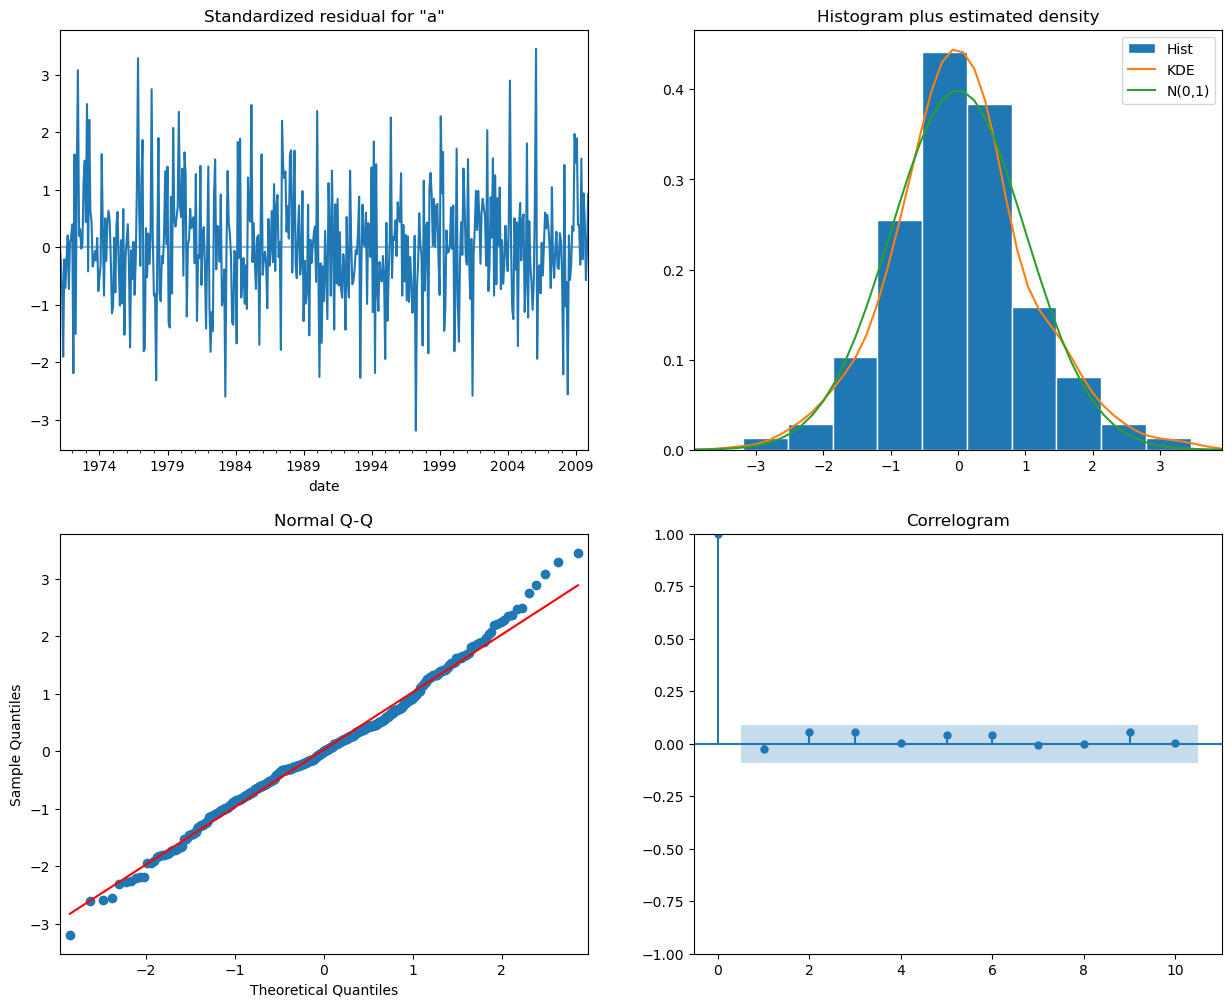

In [14]:
fitted_model.plot_diagnostics(figsize = (15, 12))
plt.show()

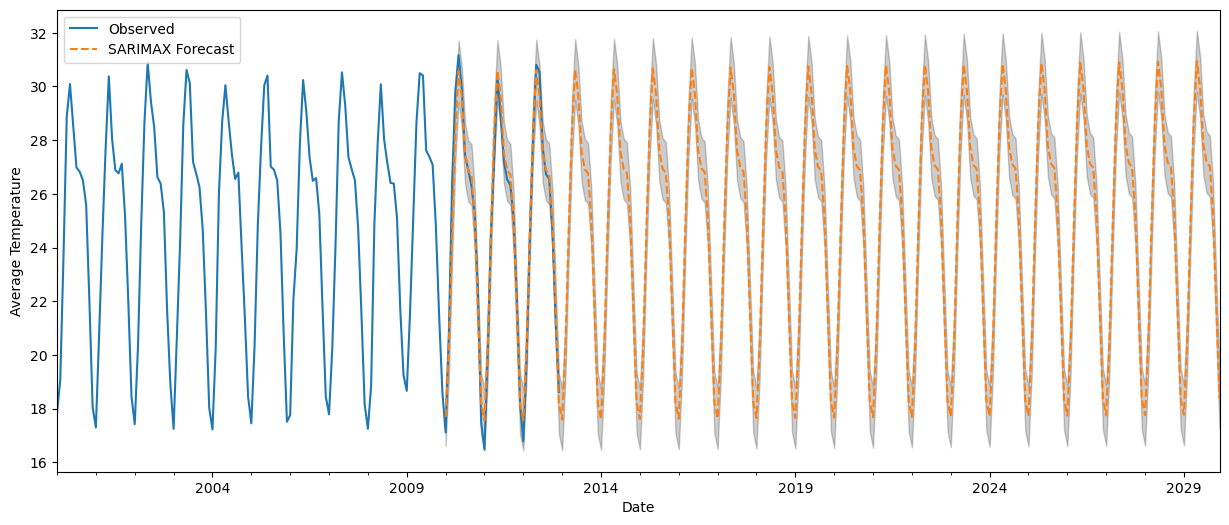

In [15]:
#Getting the SARIMAX forecast with number of steps as 36 since we want to make 3 year prediction and our data is monthly sampled.
pred = fitted_model.get_forecast(steps = 240)
#Plotting the observed and forecasted values:
ax1 = y['2000':].plot(label = 'Observed')
pred.predicted_mean.plot(ax = ax1, label = 'SARIMAX Forecast', figsize = (15, 6), linestyle = 'dashed')
#Finding the confidence intervals of the forecasts.
pred_ci = pred.conf_int()
ax1.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color = 'k', alpha = 0.2)
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Temperature')
plt.legend(loc = 'upper left')
plt.show()

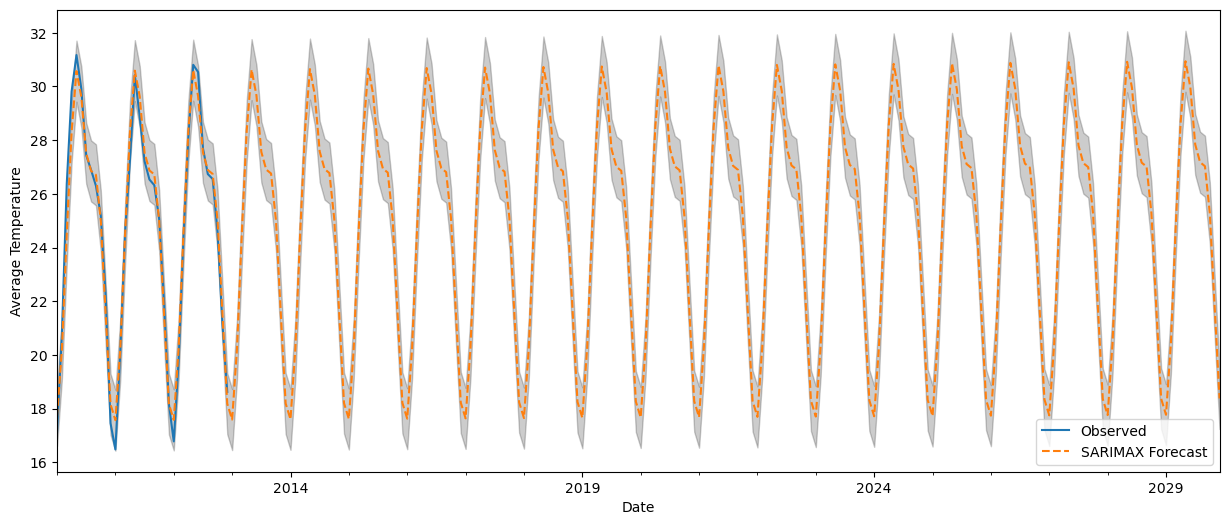

In [16]:
#Plotting the observed and forecasted values:
ax2 = y['2010':].plot(label = 'Observed')
pred.predicted_mean.plot(ax = ax2, label = 'SARIMAX Forecast', figsize = (15, 6), linestyle = 'dashed')
#Finding the confidence intervals of the forecasts.
pred_ci = pred.conf_int()
ax2.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color = 'k', alpha = 0.2)
ax2.set_xlabel('Date')
ax2.set_ylabel('Average Temperature')
plt.legend()
plt.show()

In [17]:
y_forecasted_SARIMAX = pred.predicted_mean
y_truth = test
mse_SARIMAX = ((y_forecasted_SARIMAX - y_truth) ** 2).mean()
print('The Mean Squared Error of SARIMAX forecast is {}'.format(round(mse_SARIMAX, 2)))
print('The Root Mean Squared Error of SARIMAX forecast is {}'.format(round(np.sqrt(mse_SARIMAX), 2)))

The Mean Squared Error of SARIMAX forecast is 0.38
The Root Mean Squared Error of SARIMAX forecast is 0.62


# The RMSE tells us that the SARIMAX model was able to forecast the monthly average temperature within 0.62°C of the true temperature.